In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="6"

Tue Jan 16 18:37:44 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   31C    P0    43W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.prior.spiral_prior import Prior
from model.latent.lse_latent import Latent
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 1
hp.out_dim = 1
hp.z_dim = 2
hp.h_dims = [32, 64, 128, 256, 512]
hp.M = 1024
hp.N = 256

In [5]:
''' Find Optimum Log-Sigma'''
from util.loglikelihood import get_optimum_log_sigma
from util.spiral import generate_spiral_data_torch

p_samples1 = generate_spiral_data_torch(hp.M//5, 5)[0].cuda()
p_samples2 = generate_spiral_data_torch(hp.N//5, 5)[0].cuda()
log_sigmas = np.array([get_optimum_log_sigma(p_samples1, p_samples2) for _ in range(100)])
optimum_log_sigma = np.median(log_sigmas)
print(optimum_log_sigma)

hp.init_log_sigma = optimum_log_sigma

-2.8181818181818183


In [6]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(10):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 6.004646301269531
encoder.convs 5.989013671875
encoder.linear 0.01563262939453125
prior 0.0
latent 3.814697265625e-06
decoder 6.044322967529297
decoder.linear 0.0234375
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [7]:
save_dir = '/data/scpark/save/lse/train01.16-6/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, models, opt_g = load(save_dir, 0, models, optimizer)

total 8
-rw-rw-r-- 1 scpark scpark 40  1월 16 18:37 events.out.tfevents.1705397834.GPUSVR11
-rw-rw-r-- 1 scpark scpark 40  1월 16 18:37 events.out.tfevents.1705397798.GPUSVR11


### Dataset

In [8]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 32x32
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5), (0.5)) 
])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(mnist_trainset, batch_size=hp.N, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=2048, shuffle=True)
print('done')

done


### Preprocess

In [9]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [10]:
def plot(x):
    _x = x.data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i, 0])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


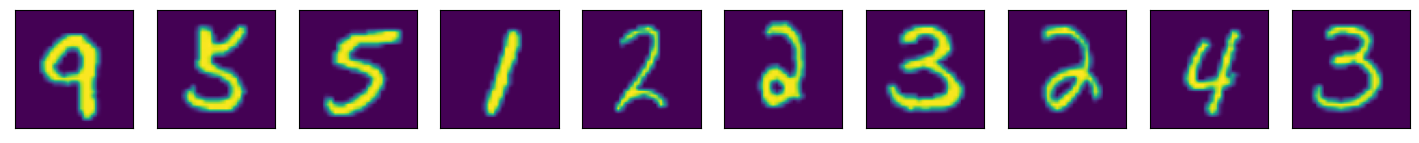

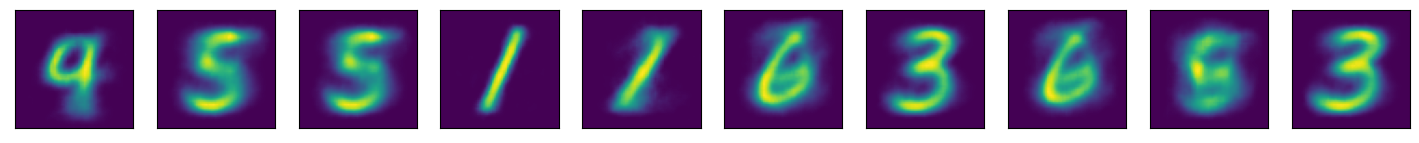

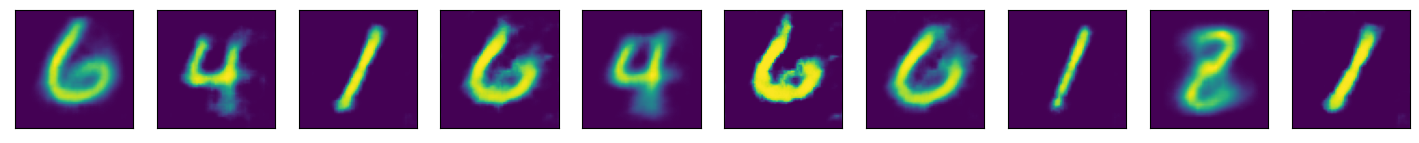

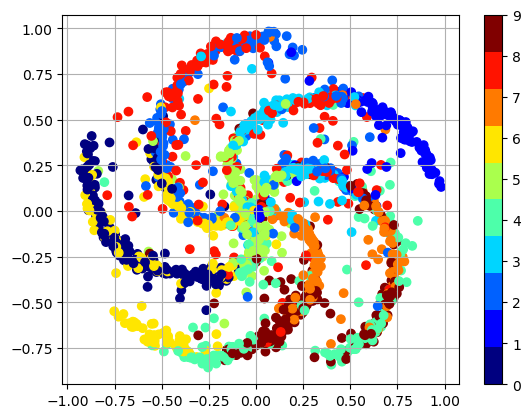

10001
lse_loss -2.086347150802612
recon_loss 0.16105792224407195
10002
lse_loss -2.077099084854126
recon_loss 0.16209251284599305
10003
lse_loss -2.062023162841797
recon_loss 0.16239627748727797
10004
lse_loss -2.077080726623535
recon_loss 0.166011044383049
10005
lse_loss -2.09007306098938
recon_loss 0.167938232421875
10006
lse_loss -2.065742301940918
recon_loss 0.168154077231884
10007
lse_loss -2.0821388244628904
recon_loss 0.15449787825345992
10008
lse_loss -2.0893550872802735
recon_loss 0.1501538187265396
10009
lse_loss -2.070715093612671
recon_loss 0.1602171167731285
10010
lse_loss -2.078386926651001
recon_loss 0.16481394916772843
10011
lse_loss -2.112614965438843
recon_loss 0.16225974261760712
10012
lse_loss -2.079182243347168
recon_loss 0.16587155759334565
10013
lse_loss -2.081494760513306
recon_loss 0.1589452937245369
10014
lse_loss -2.0763906478881835
recon_loss 0.16370345205068587
10015
lse_loss -2.0816807746887207
recon_loss 0.1659223183989525
10016
lse_loss -2.08647885322570

10127
lse_loss -2.079604721069336
recon_loss 0.1638778954744339
10128
lse_loss -2.0659681797027587
recon_loss 0.15257299393415452
10129
lse_loss -2.0715939521789553
recon_loss 0.16197015047073365
10130
lse_loss -2.0773717880249025
recon_loss 0.16661491394042968
10131
lse_loss -2.0989118576049806
recon_loss 0.1540895164012909
10132
lse_loss -2.068024158477783
recon_loss 0.15136244297027587
10133
lse_loss -2.063468647003174
recon_loss 0.17014809101819992
10134
lse_loss -2.0878098011016846
recon_loss 0.15701550394296646
10135
lse_loss -2.108849573135376
recon_loss 0.1613987684249878
10136
lse_loss -2.09684796333313
recon_loss 0.15534608960151672
10137
lse_loss -2.1082592010498047
recon_loss 0.15462807863950728
10138
lse_loss -2.0949246883392334
recon_loss 0.16124842911958695
10139
lse_loss -2.078253889083862
recon_loss 0.16096776276826857
10140
lse_loss -2.0667467594146727
recon_loss 0.1574884057044983
10141
lse_loss -2.0949642181396486
recon_loss 0.15252553075551986
10142
lse_loss -2.104

10253
lse_loss -2.1049397945404054
recon_loss 0.16343413293361664
10254
lse_loss -2.0990719318389894
recon_loss 0.15664739459753035
10255
lse_loss -2.0593114376068113
recon_loss 0.16516073495149614
10256
lse_loss -2.078699827194214
recon_loss 0.16249808371067048
10257
lse_loss -2.0986720085144044
recon_loss 0.15844549834728242
10258
lse_loss -2.086116170883179
recon_loss 0.15660842061042785
10259
lse_loss -2.067970943450928
recon_loss 0.165804360806942
10260
lse_loss -2.1054203510284424
recon_loss 0.15733965188264848
10261
lse_loss -2.0739630699157714
recon_loss 0.16089511811733245
10262
lse_loss -2.1250842094421385
recon_loss 0.15814356356859208
10263
lse_loss -2.091717338562012
recon_loss 0.16151897460222245
10264
lse_loss -2.108073425292969
recon_loss 0.15503454208374023
10265
lse_loss -2.103956699371338
recon_loss 0.15402072966098784
10266
lse_loss -2.090868616104126
recon_loss 0.15640431344509126
10267
lse_loss -2.0782104969024657
recon_loss 0.15824878662824632
10268
lse_loss -2.0

lse_loss -2.090043640136719
recon_loss 0.16048712879419327
10380
lse_loss -2.078564739227295
recon_loss 0.1586224317550659
10381
lse_loss -2.082852506637573
recon_loss 0.16120695918798447
10382
lse_loss -2.083144998550415
recon_loss 0.1657418504357338
10383
lse_loss -2.092524766921997
recon_loss 0.15504662841558456
10384
lse_loss -2.092453050613403
recon_loss 0.1663490891456604
10385
lse_loss -2.1003795146942137
recon_loss 0.16051373779773712
10386
lse_loss -2.0875408172607424
recon_loss 0.16285728216171264
10387
lse_loss -2.065635585784912
recon_loss 0.15213248878717422
10388
lse_loss -2.074534273147583
recon_loss 0.15607872903347014
10389
lse_loss -2.0869714260101317
recon_loss 0.15918738543987274
10390
lse_loss -2.1146383762359617
recon_loss 0.160897596180439
10391
lse_loss -2.0879032135009767
recon_loss 0.1600261002779007
10392
lse_loss -2.0911717414855957
recon_loss 0.15192853212356566
10393
lse_loss -2.0668619155883787
recon_loss 0.15682687759399414
10394
lse_loss -2.096229314804

lse_loss -2.087790584564209
recon_loss 0.1612044468522072
10506
lse_loss -2.0963329792022707
recon_loss 0.15823425948619843
10507
lse_loss -2.083095407485962
recon_loss 0.1633331760764122
10508
lse_loss -2.074124240875244
recon_loss 0.16371231228113176
10509
lse_loss -2.0990046501159667
recon_loss 0.15809634029865266
10510
lse_loss -2.1086760997772216
recon_loss 0.15554024875164033
10511
lse_loss -2.0903443336486816
recon_loss 0.15870866775512696
10512
lse_loss -2.093724489212036
recon_loss 0.16160717457532883
10513
lse_loss -2.100782346725464
recon_loss 0.16553342640399932
10514
lse_loss -2.0934770584106444
recon_loss 0.1603321298956871
10515
lse_loss -2.0920258522033692
recon_loss 0.16288794875144957
10516
lse_loss -2.08998966217041
recon_loss 0.15757388472557068
10517
lse_loss -2.089530897140503
recon_loss 0.15893228799104692
10518
lse_loss -2.0992934703826904
recon_loss 0.15363225489854812
10519
lse_loss -2.0852533340454102
recon_loss 0.15952458530664443
10520
lse_loss -2.120318174

10631
lse_loss -2.0971810817718506
recon_loss 0.15137127935886383
10632
lse_loss -2.104108190536499
recon_loss 0.16494977325201035
10633
lse_loss -2.101265478134155
recon_loss 0.15272125899791716
10634
lse_loss -2.0912904739379883
recon_loss 0.15797035545110702
10635
lse_loss -2.096486043930054
recon_loss 0.15440938919782637
10636
lse_loss -2.100100612640381
recon_loss 0.16212271600961686
10637
lse_loss -2.0726130962371827
recon_loss 0.16825032979249954
10638
lse_loss -2.082723045349121
recon_loss 0.1648639991879463
10639
lse_loss -2.0990580558776855
recon_loss 0.15914999544620514
10640
lse_loss -2.09815993309021
recon_loss 0.15201232880353927
10641
lse_loss -2.101415491104126
recon_loss 0.16024071276187896
10642
lse_loss -2.0894140243530273
recon_loss 0.1688654512166977
10643
lse_loss -2.1050766944885253
recon_loss 0.15500582307577132
10644
lse_loss -2.0894723892211915
recon_loss 0.16614107489585878
10645
lse_loss -2.0889708042144775
recon_loss 0.1636470764875412
10646
lse_loss -2.095

lse_loss -2.1089514255523683
recon_loss 0.155698324739933
10758
lse_loss -2.0709867000579836
recon_loss 0.16750034540891648
10759
lse_loss -2.1046289443969726
recon_loss 0.15738953948020934
10760
lse_loss -2.083565330505371
recon_loss 0.15040667355060577
10761
lse_loss -2.104750156402588
recon_loss 0.15645561516284942
10762
lse_loss -2.08499960899353
recon_loss 0.16123948991298676
10763
lse_loss -2.0775287628173826
recon_loss 0.1542631059885025
10764
lse_loss -2.1054108142852783
recon_loss 0.14878592193126677
10765
lse_loss -2.06399827003479
recon_loss 0.15815880447626113
10766
lse_loss -2.0867257118225098
recon_loss 0.15603794455528258
10767
lse_loss -2.0895901679992677
recon_loss 0.15467189699411393
10768
lse_loss -2.0790538787841797
recon_loss 0.15364940613508224
10769
lse_loss -2.09028639793396
recon_loss 0.1617342635989189
10770
lse_loss -2.091523027420044
recon_loss 0.16201728880405425
10771
lse_loss -2.085896444320679
recon_loss 0.15976063013076783
10772
lse_loss -2.099718761444

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, M=hp.M)

            # Backward
            loss = 0
            for key in data.keys():
                if 'kl_loss' in key:
                    loss = loss + data[key] * 0.00025
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
        
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model = model_list[0]
            model.eval()
            with torch.no_grad():
                data = model(data, M=hp.M)
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = torch.randn(10, hp.z_dim).to(device)
                y = model.sample(z)
                plot(y)
                
            import matplotlib.pyplot as plt
            _z = data['z'].data.cpu().numpy()
            plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'))
            plt.grid()
            plt.colorbar()
            plt.show()
        
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        